# [문서 벡터를 이용한 추천 시스템]

### 1. 모듈 및 데이터 로드

In [ ]:
import urllib.request
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import re
from PIL import Image
from io import BytesIO
from nltk.tokenize import RegexpTokenizer
import nltk
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from nltk.corpus import stopwords
from sklearn.metrics.pairwise import cosine_similarity
from google.colab import drive
drive.mount('/content/drive', force_remount=True)



Mounted at /content/drive


In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
df = pd.read_csv("/content/drive/My Drive/mypractice/data.csv")
print('전체 문서의 수 :',len(df))

전체 문서의 수 : 2382


In [ ]:
df[:5]

,Unnamed: 0,Desc,Unnamed: 0.1,author,genre,image_link,rating,title,cleaned
0,0,We know that power is shifting: From West to E...,0.0,Moisés Naím,Business,https://i.gr-assets.com/images/S/compressed.ph...,3.63,The End of Power: From Boardrooms to Battlefie...,we know that power is shifting: from west to e...
1,1,Following the success of The Accidental Billio...,1.0,Blake J. Harris,Business,https://i.gr-assets.com/images/S/compressed.ph...,3.94,"Console Wars: Sega, Nintendo, and the Battle t...",following the success of the accidental billio...
2,2,How to tap the power of social software and ne...,2.0,Chris Brogan,Business,https://i.gr-assets.com/images/S/compressed.ph...,3.78,Trust Agents: Using the Web to Build Influence...,how to tap the power of social software and ne...
3,3,William J. Bernstein is an American financial ...,3.0,William J. Bernstein,Business,https://i.gr-assets.com/images/S/compressed.ph...,4.20,The Four Pillars of Investing,william j. bernstein is an american financial ...
4,4,Amazing book. And I joined Steve Jobs and many...,4.0,Akio Morita,Business,https://i.gr-assets.com/images/S/compressed.ph...,4.05,Made in Japan: Akio Morita and Sony,amazing book. and i joined steve jobs and many...


### 2. 데이터 전처리

In [ ]:
def _removeNonAscii(s):
    return "".join(i for i in s if  ord(i)<128)

def make_lower_case(text):
    return text.lower()

def remove_stop_words(text):
    text = text.split()
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops]
    text = " ".join(text)
    return text

def remove_html(text):
    html_pattern = re.compile('<.*?>')
    return html_pattern.sub(r'', text)

def remove_punctuation(text):
    tokenizer = RegexpTokenizer(r'[a-zA-Z]+')
    text = tokenizer.tokenize(text)
    text = " ".join(text)
    return text

df['cleaned'] = df['Desc'].apply(_removeNonAscii)
df['cleaned'] = df.cleaned.apply(make_lower_case)
df['cleaned'] = df.cleaned.apply(remove_stop_words)
df['cleaned'] = df.cleaned.apply(remove_punctuation)
df['cleaned'] = df.cleaned.apply(remove_html)

In [ ]:
df['cleaned'][:5]

0    know power shifting west east north south pres...
1    following success accidental billionaires mone...
2    tap power social software networks build busin...
3    william j bernstein american financial theoris...
4    amazing book joined steve jobs many akio morit...
Name: cleaned, dtype: object

In [ ]:
df['cleaned'].replace('', np.nan, inplace=True)
df = df[df['cleaned'].notna()]
print('전체 문서의 수 :',len(df))

전체 문서의 수 : 2381


토큰화 수행 후 corpus에 저장

In [ ]:
corpus = []
for words in df['cleaned']:
    corpus.append(words.split())

### 3. Word2Vec 사용하기

In [ ]:
urllib.request.urlretrieve("https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz", \
                           filename="GoogleNews-vectors-negative300.bin.gz")

('GoogleNews-vectors-negative300.bin.gz',
 <http.client.HTTPMessage at 0x7f148d63e490>)

In [ ]:
word2vec_model = Word2Vec(size = 300, window=5, min_count = 2, workers = -1)
word2vec_model.build_vocab(corpus)
word2vec_model.intersect_word2vec_format('GoogleNews-vectors-negative300.bin.gz', lockf=1.0, binary=True)
word2vec_model.train(corpus, total_examples = word2vec_model.corpus_count, epochs = 15)

(0, 0)

### 4. 단어 벡터의 평균 구하기

In [ ]:
def vectors(document_list):
    document_embedding_list = []

    # 각 문서에 대해서
    for line in document_list:
        doc2vec = None
        count = 0
        for word in line.split():
            if word in word2vec_model.wv.vocab:
                count += 1
                # 해당 문서에 있는 모든 단어들의 벡터값을 더한다.
                if doc2vec is None:
                    doc2vec = word2vec_model[word]
                else:
                    doc2vec = doc2vec + word2vec_model[word]

        if doc2vec is not None:
            # 단어 벡터를 모두 더한 벡터의 값을 문서 길이로 나눠준다.
            doc2vec = doc2vec / count
            document_embedding_list.append(doc2vec)

    # 각 문서에 대한 문서 벡터 리스트를 리턴
    return document_embedding_list

In [ ]:
document_embedding_list = vectors(df['cleaned'])
print('문서 벡터의 수 :',len(document_embedding_list))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  from ipykernel import kernelapp as app


문서 벡터의 수 : 2381


### 5. 추천 시스템 구현하기

In [ ]:
cosine_similarities = cosine_similarity(document_embedding_list, document_embedding_list)
print('코사인 유사도 매트릭스의 크기 :',cosine_similarities.shape)

코사인 유사도 매트릭스의 크기 : (2381, 2381)


In [ ]:
def recommendations(title):
    books = df[['title', 'image_link']]

    # 책의 제목을 입력하면 해당 제목의 인덱스를 리턴받아 idx에 저장.
    indices = pd.Series(df.index, index = df['title']).drop_duplicates()    
    idx = indices[title]

    # 입력된 책과 줄거리(document embedding)가 유사한 책 5개 선정.
    sim_scores = list(enumerate(cosine_similarities[idx]))
    sim_scores = sorted(sim_scores, key = lambda x: x[1], reverse = True)
    sim_scores = sim_scores[1:6]

    # 가장 유사한 책 5권의 인덱스
    book_indices = [i[0] for i in sim_scores]

    # 전체 데이터프레임에서 해당 인덱스의 행만 추출. 5개의 행을 가진다.
    recommend = books.iloc[book_indices].reset_index(drop=True)

    fig = plt.figure(figsize=(20, 30))

    # 데이터프레임으로부터 순차적으로 이미지를 출력
    for index, row in recommend.iterrows():
        response = requests.get(row['image_link'])
        img = Image.open(BytesIO(response.content))
        fig.add_subplot(1, 5, index + 1)
        plt.imshow(img)
        plt.title(row['title'])

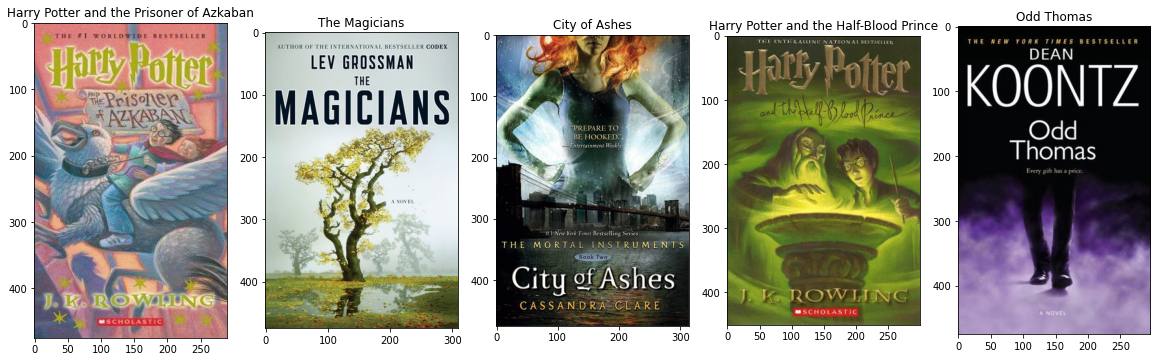

In [ ]:
recommendations("Harry Potter and the Sorcerer's Stone")
#Detective Conan 없음

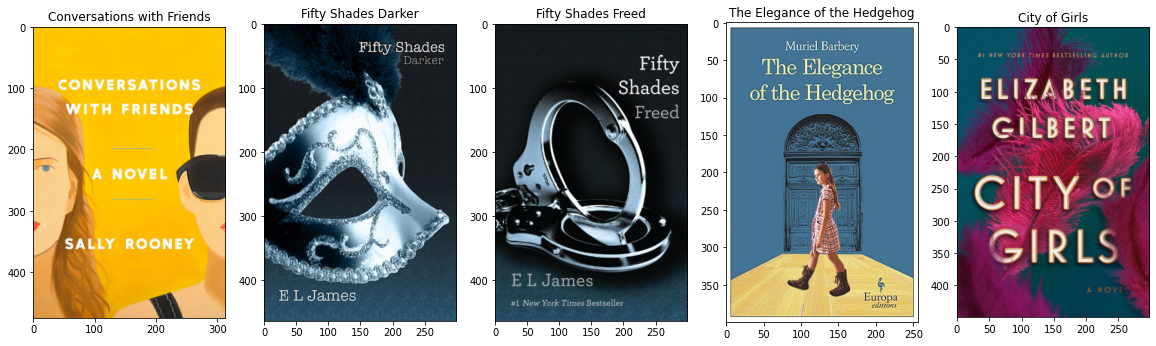

In [ ]:
recommendations("Fifty Shades of Grey")

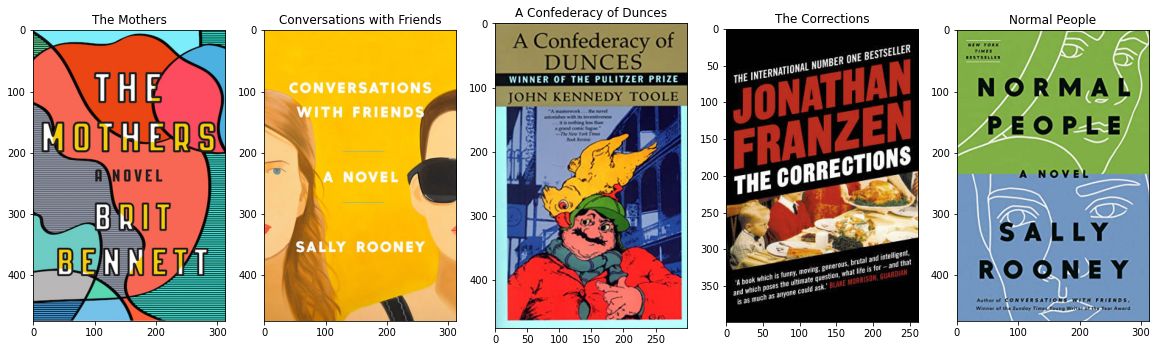

In [ ]:
recommendations("Matilda")

# [워드 임베딩의 평균]

### 1. 모듈 로드 및 데이터 준비

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.datasets import imdb

In [ ]:
vocab_size = 20000

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=vocab_size)
print('훈련용 리뷰 개수 :',len(x_train))
print('테스트용 리뷰 개수 :',len(x_test))

17465344/17464789 [==============================] - 0s 0us/step


<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])


훈련용 리뷰 개수 : 25000
테스트용 리뷰 개수 : 25000


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


In [ ]:
print(x_train[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 19193, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 10311, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 12118, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


In [ ]:
print(y_train[0]) #첫번째 리뷰가 긍정 리뷰

1


In [ ]:
print('훈련용 리뷰의 평규 길이: {}'.format(np.mean(list(map(len, x_train)), dtype=int)))
print('테스트용 리뷰의 평균 길이: {}'.format(np.mean(list(map(len, x_test)), dtype=int)))

훈련용 리뷰의 평규 길이: 238
테스트용 리뷰의 평균 길이: 230


In [ ]:
## 데이터 패딩##

max_len = 400

x_train = pad_sequences(x_train, maxlen=max_len)
x_test = pad_sequences(x_test, maxlen=max_len)
print('x_train의 크기(shape) :', x_train.shape)
print('x_test의 크기(shape) :', x_test.shape)

x_train의 크기(shape) : (25000, 400)
x_test의 크기(shape) : (25000, 400)


### 2. 모델 설계

In [ ]:
model = Sequential()
model.add(Embedding(vocab_size, 50, input_length=max_len))
model.add(GlobalAveragePooling1D()) # 모든 단어 벡터의 평균을 구한다.
model.add(Dense(1, activation='sigmoid'))

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('embedding_average_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
model.fit(x_train, y_train, batch_size=32, epochs=10, callbacks=[es, mc], validation_split=0.2)

Epoch 1/10
625/625 [==============================] - 11s 17ms/step - loss: 0.6718 - acc: 0.6568 - val_loss: 0.5433 - val_acc: 0.8062

Epoch 00001: val_acc improved from -inf to 0.80620, saving model to embedding_average_model.h5
Epoch 2/10
625/625 [==============================] - 11s 17ms/step - loss: 0.4948 - acc: 0.8329 - val_loss: 0.4026 - val_acc: 0.8502

Epoch 00002: val_acc improved from 0.80620 to 0.85020, saving model to embedding_average_model.h5
Epoch 3/10
625/625 [==============================] - 11s 17ms/step - loss: 0.3568 - acc: 0.8830 - val_loss: 0.3366 - val_acc: 0.8750

Epoch 00003: val_acc improved from 0.85020 to 0.87500, saving model to embedding_average_model.h5
Epoch 4/10
625/625 [==============================] - 11s 17ms/step - loss: 0.2840 - acc: 0.9033 - val_loss: 0.3075 - val_acc: 0.8852

Epoch 00004: val_acc improved from 0.87500 to 0.88520, saving model to embedding_average_model.h5
Epoch 5/10
625/625 [==============================] - 11s 17ms/step - l

In [ ]:
loaded_model = load_model('embedding_average_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(x_test, y_test)[1]))

782/782 [==============================] - 2s 3ms/step - loss: 0.2816 - acc: 0.8880

 테스트 정확도: 0.8880
